# Prueba Técnica MELI Clusterización de Sellers

🧠  Este script está diseñado para extraer información de la página de Mercado Libre utilizando Scrapy y la API oficial proporcionada por la plataforma. Una vez obtenidos los datos, se realiza un preprocesamiento y limpieza para garantizar su calidad. Posteriormente, los datos se utilizan como base para implementar una solución analítica de clusterización, con el objetivo de identificar patrones o segmentos relevantes.

## Recolección de información

Según información publicada por el sitio oficial de [Mercado Libre](https://vendedores.mercadolibre.com.co/nota/los-productos-mas-vendidos-en-internet-10-ideas-para-tu-shop) uno de los productos más atractivos para los clientes con una amplia gama de seguidores son los productos electrónicos.

Debido a este alto nivel de interés, se seleccionó esta categoría como enfoque principal para identificar clientes potenciales y desarrollar estrategias de segmentación efectivas.


### Utilización de la API y scrapy 

Con extraer de forma masiva links de productos tecnológicos se utilizó el framework Scrapy. A Partir de la construcción de una "araña" se navega a través de diversas páginas extrayendo su dirección URL.

Una vez se haya ambientado el entorno de python deirijare al archivo ```web_scraping.py``` y ejeutelo mediante el siguinte comando ```scrapy runspider meli_produtcos_tres.py -o datos_meli_uno_cel.json```.
Lo anterior retorna una lista de diccionarios que albergan las direcciones url de los productos. (Para este  caso practico ya se cuenta con el archivo ```web_scraping.py``` ) 

Una vez consolidado el archivo de datos,se realiza análisis y procesamiento. A continuacion los detalles




In [35]:
import pandas as pd
import re
from paquete_clustering.utils import UtilsClustering
import requests
import time
from geopy.geocoders import Nominatim
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score,silhouette_score
import mysql.connector
from sqlalchemy import create_engine

from sqlalchemy.types import Integer, String,BigInteger



In [2]:
total_urls = pd.read_json("urls_file.json")
total_urls = [url for _, row in total_urls.iterrows()  for url in row["url_"]]
total_productos = [re.search(r'([/p/])+(MCO[\d]+)', url).group(2) for url in total_urls if re.search(r'([/p/])+(MCO[\d]+)', url) ]
total_productos = sorted(set(total_productos))

💡 Al tener en una lista los distintos productos se realiza el llamado a la API para conocer información más detallada de los mismo, no sin  antes realizar el proceso de autenticación exigido por
[Mercado Libre](https://developers.mercadolibre.com.co/es_ar/crea-una-aplicacion-en-mercado-libre-es)

In [3]:
with open("config.json") as f:
    config = eval(f.read())
utils_clustering =UtilsClustering(configraciones=config)


In [4]:
dato = utils_clustering.actualizar_token(config["nuevo_token"])

Solicitud post exitosa
Respuesta:
{"access_token":"APP_USR-1271746154574690-073113-5abf2e691e05d6dca29e197a318e1980-2583130070","token_type":"Bearer","expires_in":21600,"scope":"offline_access read urn:global:admin:users:/read-only urn:global:admin:users:/read-write urn:ml:mktp:ads:/read-only urn:ml:mktp:comunication:/read-only urn:ml:mktp:invoices:/read-only urn:ml:mktp:metrics:/read-only urn:ml:mktp:offers:/read-only urn:ml:mktp:orders-shipments:/read-only urn:ml:mktp:publish-sync:/read-only write","user_id":2583130070,"refresh_token":"TG-688bad280db8210001d843c4-2583130070"}


In [5]:

headers_meli = {'Authorization':f'Bearer {eval(dato)["access_token"]}','User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'}
seller_id = []
for descrip_producto in total_productos:
    try:
        info_producto = requests.get(f'https://api.mercadolibre.com/products/{descrip_producto}/items', headers=headers_meli).json()
    except:
        print("Informacion del producto no encontrada")

    for item in info_producto.get("results",{}):
        seller_id.append(item["seller_id"])
seller_id = sorted(set(seller_id))


Al conocer el id de cada seller se llama nuevamente el API para conocer su  [informacion](https://developers.mercadolibre.com.co/es_ar/items-y-busquedas)


In [6]:
def obtener_detalle_seller(seller_id):
    resp = requests.get(f'https://api.mercadolibre.com/users/{seller_id}', headers=headers_meli)
    if resp.status_code != 200:
        return None
    info = resp.json()
    rep = info.get("seller_reputation", {})
    tx = rep.get("transactions", {})
    status = rep.get("status", {})
    return {
        "seller_id": seller_id,
        "level_id": rep.get("level_id"),
        "power_seller_status": rep.get("power_seller_status"),
        "total_transactions": tx.get("total", 0),
        "city": info.get("address", {}).get("city"),
        "status": info.get("status",{}).get("site_status"),
    }
total_sellers_info = []
for id in seller_id:
  time.sleep(0.1)
  det = obtener_detalle_seller(id)
  if det:
    total_sellers_info.append(det)

In [7]:
total_sellers_info[5]

{'seller_id': 27908895,
 'level_id': '5_green',
 'power_seller_status': None,
 'total_transactions': 283,
 'city': 'Puente Aranda',
 'status': 'active'}

Lo anterior nos arroja un diccionario con datos relevantes del seller, la   [documentación](https://developers.mercadolibre.com.ar/es_ar/reputacion-de-vendedores) nos indica que podemos ver campos esenciales como:  

* level_id: nivel de reputación del usuario, descrita en numeración y color del termometro.
* power_seller_status: este campo indica si el vendedor es Mercado Lider, y el nombre de la medalla recibida, puede ser Silver, Gold o Platinum.
* real_level: nivel real de reputación del vendedor, durante el período de protección (aparece solo cuando el vendedor está protegido).
* protection_end_date: fecha de fin de la protección (solo cuando el vendedor está protegido).
* transactions: cantidad de ventas realizadas por el usuario en un determinado periodo.
* canceled: cantidad de operaciones canceladas.
* completed: cantidad de transacciones completadas.
* period: período tenido en cuenta.
* ratings: ratio de ventas calificadas en negativas, neutras, o positivas.
* total: total de transacciones.


In [8]:
df_sellers = pd.DataFrame(total_sellers_info)
df_sellers.shape

(184, 6)

## Preparación de los datos

Una parte fundamental en la construcción de cualquier modelo de machin learning, debido a que los datos debe ser analizados y procesados de de forma muy meticulosa con el fin de
evitar resultados engaños.


En este apartado se revisa que los datos no presenten ninguna irregularidad que afecten la calidad de la información.




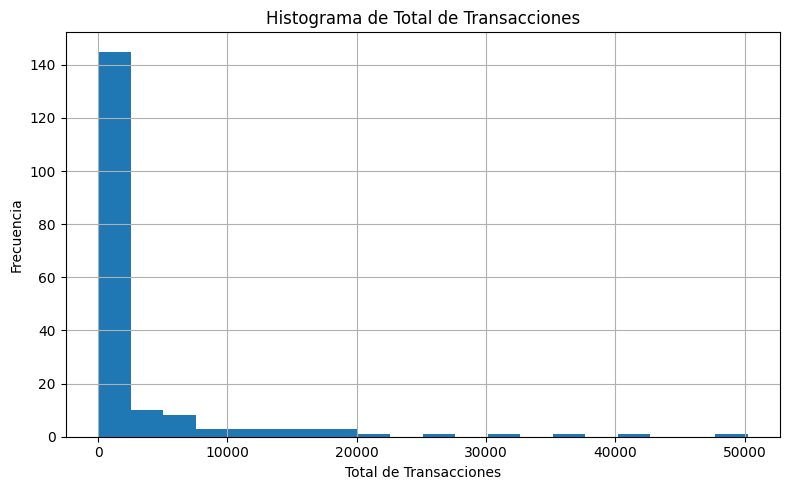

In [9]:
plt.figure(figsize=(8, 5))
df_sellers['total_transactions'].hist(bins=20)
plt.title('Histograma de Total de Transacciones')
plt.xlabel('Total de Transacciones')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

💡 De la figura anterior de observa un notorio sesgo a la derecha, indicios de  sellers inactivos o con baja actividad. Quizá muchos perfiles recién creados o tiendas con poca rotación. 

Teniendo una idea aproximada de los datos con los cuales se pretende trabajar se realiza la una estandarización y eliminación de irregularidades.

In [10]:
df_sellers['level_num'] = df_sellers['level_id'].str.extract(r'(\d+)').fillna(0).astype(int)
mapping = {'silver':1,'gold':2,'platinum':3}
df_sellers['power_num'] = df_sellers['power_seller_status'].map(mapping).fillna(0).astype(int)
scaler = StandardScaler() 
X = scaler.fit_transform(df_sellers[['total_transactions','level_num','power_num']]) 

Como el algoritmo de machine learning que se quiere implementar es el algoritmo de clustering, es de vital importancia conocer el número de cluster o grupos  que se formaran a partir de un patrón en común.
Lo anterior se consigue aplicando el método del Elbow, método basado en la distorcion promedio de cada cluster
 


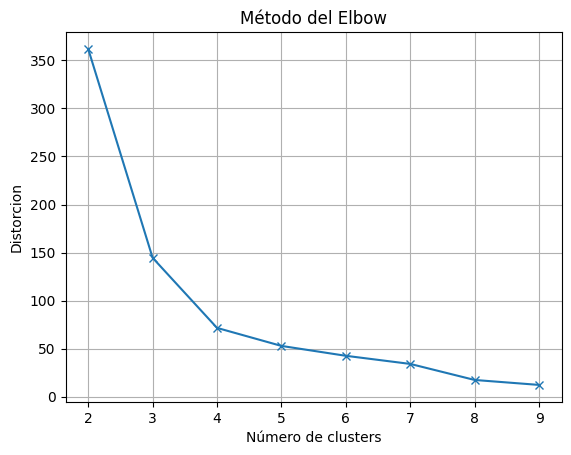

In [11]:
n_cluster = []
for i in range(2,10):
  kmeans = KMeans(n_clusters=i, random_state=42)
  kmeans.fit(X)
  n_cluster.append(kmeans.inertia_)
plt.plot(range(2,10),n_cluster, marker='x')
plt.xlabel('Número de clusters')
plt.ylabel('Distorcion')
plt.title('Método del Elbow')
plt.grid(True)
plt.show()

In [12]:
kmeans = KMeans(n_clusters=3, init="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans.fit(X) 
df_sellers['cluster'] = kmeans.fit_predict(X)

In [13]:
df_sellers.cluster.value_counts()

cluster
0    114
1     41
2     29
Name: count, dtype: int64

Al tener el modelo entrenado es muy importante evaluarlo con el fin de determinar su funcionamiento y validez. Existen diferentes métricas como muestra la [documentación](https://developers.mercadolibre.com.ar/es_ar/reputacion-de-vendedores) que podemos aplicar para realizar la evaluación
 


In [14]:
print("Índice de Davies-Bouldin: ", davies_bouldin_score(X, kmeans.labels_))  #valores cercanos a cero indican un buen clustering
print("Silhouette Score: ", silhouette_score(X, kmeans.labels_)) #valores cercanos a uno indican un buen clustering
print("Calinski-Harabasz: ", calinski_harabasz_score(X, kmeans.labels_)) #si bin no existe un valor estandar al que se llega, es util para comparalo con otro modelo. Un valor grande indica un clustering optimo


Índice de Davies-Bouldin:  0.5238773490490006
Silhouette Score:  0.6449276080925535
Calinski-Harabasz:  258.2028095749315


Conociendo que se tiene un desempeño favorable se puede generar conclusiones al respecto
 

💡 Cluster 0 (“Newbies”)


* Prácticamente 0 transacciones.
* Nivel de reputación casi siempre None
* Potencial de bajo compromiso o cuentas recién creadas

💡 Cluster 1 (“Intermedios”)


* Entre ~500 y ~5 000 transacciones.
* Reputación 5_green mayoritariamente, con estatus gold/silver.
* Sellers consolidados con volumen medio y buena reputación.

💡 Cluster 2 (“Top Sellers”)


* Más de ~5 000 transacciones, en algunos caso supera las 50.000.
* Reputación al máximo (5_green) y estatus platinum.
* Candidatos ideales para programas de fidelidad, asociaciones comerciales o promociones exclusivas.


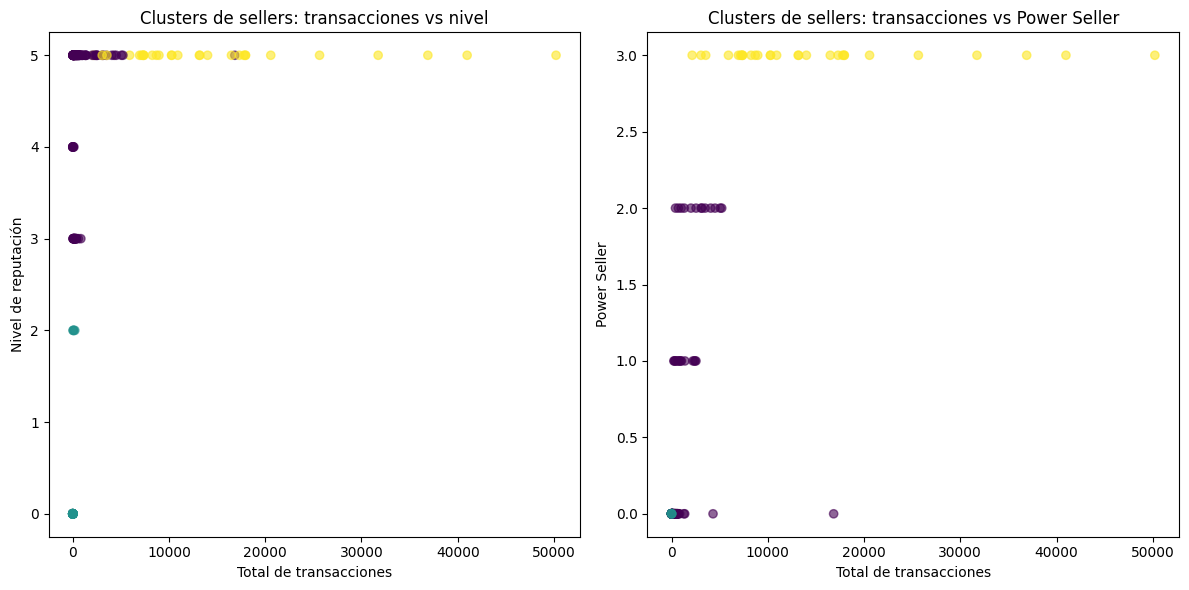

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(
    df_sellers['total_transactions'],
    df_sellers['level_num'],
    c=df_sellers['cluster'],
    alpha=0.6
)
ax1.set_xlabel('Total de transacciones')
ax1.set_ylabel('Nivel de reputación')
ax1.set_title('Clusters de sellers: transacciones vs nivel')

ax2.scatter(
    df_sellers['total_transactions'],
    df_sellers['power_num'],
    c=df_sellers['cluster'],
    alpha=0.6
)
ax2.set_xlabel('Total de transacciones')
ax2.set_ylabel('Power Seller')
ax2.set_title('Clusters de sellers: transacciones vs Power Seller')

plt.tight_layout()
plt.show()

Como se puede observar en los datos presentados, el número de ventas es  indicador crítico para el desempeño del negocio. Este hallazgo representa una métrica fundamental que requiere optimización


### 📚 Punto adicional

Como práctica fundamental, se recomienda conservar el histórico de datos con el fin de evaluar el desempeño de los sellers, medir el impacto de las campañas de mejora implementadas y realizar análisis comparativos a lo largo del tiempo. 
Por lo cual se almacena el dataframe ```df_sellers``` en una base de datos relacional (MySQL) para este caso práctico. No obstante para entornos productivos, se pueden considerar soluciones como:
* BigQuery (Google Cloud)
* Amazon Redshift (AWS)
* Snowflake
* Otras alternativas de Data Warehouse en la nube

Se parte creadondo la base de datos, para posteriomente crear la tabla y cargar los datos


```CREATE DATABASE db_ejemplo;```


  
 ```
 CREATE TABLE `sellers` (
  `seller_id` int DEFAULT NULL,
  `city` varchar(100) DEFAULT NULL,
  `total_transactions` int DEFAULT NULL,
  `level_num` int DEFAULT NULL,
  `power_num` int DEFAULT NULL,
  `cluster` int DEFAULT NULL
) 
```


In [18]:
df_sellers.head()

,seller_id,level_id,power_seller_status,total_transactions,city,status,level_num,power_num,cluster
0,2457965,None,None,0,Funza,active,0,0,1
1,5196661,2_orange,None,18,Pasto,active,2,0,1
2,8019088,5_green,gold,4509,Medellín,active,5,2,0
3,19576477,5_green,platinum,6944,Chapinero,active,5,3,2
4,27864113,None,None,0,Medellín,active,0,0,1


In [20]:
df_sellers = df_sellers[["seller_id","city","total_transactions","level_num","power_num","cluster"]]

In [ ]:

coneccion = f"mysql+mysqlconnector://{config['user']}:{config['password']}@{config['host']}/{config['database']}"


In [ ]:
dtype_mapping = {
    "seller_id": BigInteger(),
    "city": String(100),
    "total_transactions": Integer(),
    "level_num": Integer(),
    "power_num": Integer(),
    "cluster": Integer(),
}


184

In [ ]:
df_sellers.to_sql(
    name="sellers",          
    con=coneccion,
    if_exists="append",
    index=False,
    dtype=dtype_mapping,
    chunksize=500
)